# Sequence Tagging
---

<font size="4"> Tagging is the task of labelling each word in a sentence. Examples are: Part-of-Speech (POS) tagging, Named Entity Recognition (NER) and Semantic Role Labelling (SRL).
  
Sequence tagging can be treated as a set of independent classification tasks targeting each individual component of a sequence. However, ideally a model considers context when assigning labels to each component. 

Formally, the challenge in tagging is to learn a function that maps a sequence of observations x = (<i>x<sub>1</sub>,x<sub>2</sub>,....x<sub>n</sub></i>) to a label sequence y = (<i>y<sub>1</sub>,y<sub>2</sub>,...,y<sub>n</sub></i>), where <i>y<sub>i</sub></i> belongs to a set of tags, which in the case of POS tagging would be Noun, Verb, Adjective, or similar.

In some tasks, a chunk in a sequence receives a label, such as <i>Cherno More</i> or <i>Black Sea</i> in "Cherno More is the Bulgarian name of the Black Sea". 

In such cases, it is a standard practice to annotate the data using the <b>IOB scheme</b>.

Each element gets a label indicating whether it occurs in the beginning of chunk X (B-X), inside chunk X (I-x) or outside of any chunk (O).

Common issues in tagging include:
<ul>
<li> Large set of features
<li> Smaller amount of data
<li> Expensive memory and time costs
</ul>

<br>
  
---
In this notebook, we implement an <b>LSTM-based NER system</b> for CONLL2003 dataset.
  
</font>

## Let's start!
---

In [0]:
# The following two lines authorises access to Google Drive:
from google.colab import drive
drive.mount('/content/drive/')

import warnings
warnings.filterwarnings('ignore')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import numpy as np
import time
import pdb
import torch
import gensim
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

use_cuda = torch.cuda.is_available()
print("cuda device {}available".format("" if use_cuda else "un"))
device = torch.device("cuda:0" if use_cuda else "cpu")

# Parameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 200
BATCH_SIZE = 32 #300
EPOCHS = 10
LSTM_DROPOUT = 0.3
USE_PRETRAINED = False

# data dir
data_folder = "/content/drive/My Drive/Session-2B/Data"
# embeddings folder 
embed_folder = "/content/drive/My Drive/Sessin-2B/Embeddings"

cuda device available


## Data Format
---
<font size="4"> One standard file format for representing tagged pieces of text is CONLL. 
  
A CONLL file contains one token per line and an empty line indicating the end of a sentence. Each token may be annotated by several tab-separated columns indicating information about the token (e.g. token raw form) or differrent tags assigned to it (e.g. syntactic and morphological labels).
</font>

<P>
<table align="left" style="width:100%">
  <tr>
    <td>Welsh</td>
    <td>NNP</td> 
    <td>B-NP</td>
    <td><b>B-ORG</td>
  </tr>
  <tr>
    <td>National</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>Farmers</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>'</td>
    <td>POS</td> 
    <td>B-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>Union</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>(</td>
    <td>(</td> 
    <td>O</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>NFU</td>
    <td>NNP</td> 
    <td>B-NP</td>
    <td><b>B-ORG</td>
  </tr>
  <tr>
    <td>)</td>
    <td>)</td> 
    <td>O</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>chairman</td>
    <td>NN</td> 
    <td>B-NP</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>John</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>B-PER</td>
  </tr>
  <tr>
    <td>Lloyd</td>
    <td>NNP</td> 
    <td>I-NP</td>
    <td><b>I-PER</td>
  </tr>
  <tr>
    <td>said</td>
    <td>VBD</td> 
    <td>B-VP</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>on</td>
    <td>IN</td> 
    <td>B-PP</td>
    <td><b>O</td>
  </tr>
  <tr>
    <td>BBC</td>
    <td>NNP</td> 
    <td>B-NP</td>
    <td><b>B-ORG</td>
  </tr>
  <tr>
    <td>radio</td>
    <td>NN</td> 
    <td>I-NP</td>
    <td><b>I-ORG</td>
  </tr>
  <tr>
    <td>.</td>
    <td>.</td> 
    <td>O</td>
    <td><b>O</b></td>
  </tr>
  <tr>
    <td><br></tr>
    <td><font size="4"> Here, we read the CONLL 2003 dataset! <font></td>
  </tr>
</table>

<br>
</P> 


In [0]:
def readfile(filename):
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append([splits[0].strip(), splits[-1].strip()])

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    sentences = [tuple(zip(*l)) for l in sentences]
    return sentences

train_data = np.array(readfile(data_folder+'/train.txt'))
dev_data = np.array(readfile(data_folder+'/dev.txt'))
test_data = np.array(readfile(data_folder+'/test.txt'))

print("train_data shape: ",train_data.shape)
print("One instance of data: ",train_data[0])
print("dev_data shape: ",dev_data.shape)

train_data shape:  (14041, 2)
One instance of data:  [('EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.')
 ('B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O')]
dev_data shape:  (3250, 2)


## Pre-processing 
---

<font size="4">It is common to sort data instances based on their lengths. This way, the lengths of sequences in each batch would be more or less homogeneous. 
<font>

In [0]:
# This reordering is useful for padding
def tensor_reorder(data):
    """reorders tensors from longest to shortest"""
    lengths = [len(i[0]) for i in data]
    max_len = max(lengths)
    lengths = torch.LongTensor(lengths)
    lengths, perm_idx = lengths.sort(0, descending=True)
    data = data[perm_idx]
    return data

train_data = tensor_reorder(train_data)
dev_data = tensor_reorder(dev_data)
test_data = tensor_reorder(test_data)

MAX_LEN = max(len(train_data[0][0]), len(dev_data[0][0])) # we set the maximum length from the max seq in train 

In [0]:
# Here, we create a dictionary that maps all words to indices (for encoding)

all_words = list(set([w for sent in np.concatenate((train_data,dev_data), axis=0) for w in sent[0]]))

word_to_ix = {t:i+2 for i, t in enumerate(all_words)}

word_to_ix['<PAD>'] = 0
word_to_ix['<UNK>'] = 1

# The tagset is simplified (NE categories not included) 
tag_to_ix = {'<PAD>':0, 'B-MISC':1, 'B-LOC':1, 'B-ORG':1, 'B-PER':1,
             'I-MISC':2, 'I-PER':2, 'I-ORG':2, 'I-LOC':2, 'O':3}
ix_to_tag = {0:'<PAD>', 1:'B', 2:'I', 3:'O'}

## If we wanted to consider tags in their entirety:
# all_tags = list(set([tag for sent_tag in train_data for tag in sent_tag[1]]))
# tag_to_ix = {t:i+1 for i, t in enumerate(all_tags)}
# tag_to_ix['<PAD>'] = 0
# ix_to_tag = {v: k for k, v in tag_to_ix.items()}

## Dataset class and Dataloading
---

<font size="4">The standard way to represent a dataset in PyTorch is through the `utils.data.Dataset` class. In order to define your dataset, your custom class should inherit from `Dataset` and override the following two methods:
    
1. `__len__` which returns the size of the dataset  
2. `__getitem__` which receives an index `i`, returning the representation for the i*th* sample in the dataset  

You can define other arbitrary methods depending on your specific requirements.         
    
<font>

In [0]:
# This class representa the dataset.
class CoNLL2003NER(Dataset):

    def __init__(self, X, max_len, word_to_ix, tag_to_ix):
        self.X = X
        self.max_len = max_len
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        
    def transform(self, seq, to_ix):
        """Transorm and prepare one data instance"""
        idxs = [to_ix[w] if w in to_ix else 1 for w in seq]
        if len(idxs) >= self.max_len:
            # Truncating
            idxs = idxs[:self.max_len]    
        else:
            # Padding
            idxs += [0]*(self.max_len-len(seq))
        # torch.long tensors are usually used for indexing 
        return torch.tensor(idxs, dtype=torch.long)

    def __len__(self):
        """Return the length of the dataset"""
        return len(self.X)

    def __getitem__(self, idx):
        """Given an index, return its corresponding item in the dataset"""
        return self.transform(self.X[idx][0],self.word_to_ix), \
               self.transform(self.X[idx][1], self.tag_to_ix)

<font size="4"> In order to iterate over a `Dataset` instance, PyTorch provides the `torch.utils.data.DataLoader` which offers the following functionalities:

1.   create batches of data to be fed to a network 
2.   shuffling the data instances 
3.   loading instances using the multiprocessing workers 
    <font>

In [0]:
# Depending on the batch size, `drop_last` might be set to `True` in order to drop the final smaller batch.

params = {'batch_size': BATCH_SIZE,
          'shuffle': False,
          'num_workers': 6,
          'drop_last':True}

params_test = {'batch_size': 1, # batch is set to 1 not to drop any instances here
          'shuffle': False,
          'num_workers': 6,
          'drop_last':True}

train_data = CoNLL2003NER(train_data, MAX_LEN, word_to_ix, tag_to_ix)
train_data_generator = DataLoader(train_data, **params)

dev_data = CoNLL2003NER(dev_data, MAX_LEN, word_to_ix, tag_to_ix)
dev_data_generator = DataLoader(dev_data, **params)

test_data = CoNLL2003NER(test_data, MAX_LEN, word_to_ix, tag_to_ix)
test_data_generator = DataLoader(test_data, **params_test)

## Define the Model

<font size="4"> In PyTorch, models are defined by creating classes that inherit from `torch.nn.Module`. Defining a model involves two critical steps:
    

1.   Specifying the components of the model in the `__init__` constructor
2.   Outlining the way these components interact in the `forward` method
  </font>

In [0]:
# A simple LSTM Tagger
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, max_len):
        super(LSTMTagger, self).__init__()
        
        # load weights from pre-trained vectors or with random initialization
        if not USE_PRETRAINED:
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
        else: 
            # load weights from pre-trained vectors 
            self.word_embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
            
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=LSTM_DROPOUT)
    
   
        # The linear layer that maps from hidden space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence): 
        embeds = self.word_embeddings(sentence)     # SHAPE: [BATCH_SIZE,MAX_LEN,WORD_EMBEDDING_DIM]
        
        lstm_out, _ = self.lstm(embeds)

        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1) 
        
        return tag_scores

In [0]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(ix_to_tag), MAX_LEN).to(device)

# The negative log likelihood loss. 
# It is useful to train a classification problem with C classes.
loss_function = nn.NLLLoss(ignore_index=0)  
optimizer = optim.Adam(model.parameters(), lr = 0.001) 

print(model)

LSTMTagger(
  (word_embeddings): Embedding(26885, 300)
  (lstm): LSTM(300, 200, batch_first=True, dropout=0.3)
  (hidden2tag): Linear(in_features=200, out_features=4, bias=True)
)


## Training

<font size="4">In PyTorch, you have control over all the stages of the training, from iteration over the data, to adjusting the gradients, calculating the loss and backpropagation given the computed loss. 

The training procedure involves two for-loops. The inner loop is over the batches of the data. Here is where per-batch loss is computed and model parameters are updated using an optimizer. 

The inner loop is composed of the following essential steps:

1. Clear the gradients. Remember that gradients accumulate over time. In each batch, they need to be reset.  

2. Run forward pass and generate an output. 

3. Pass the output and the gold-standard training labels to the loss function to estimate the degree of deviation from the true labels.   

4. Call the `backward()` method on the loss object. This will compute gradients $\frac{\partial loss}{\partial x}$ for every parameter x whose `requires_grad` is set to `True`. In order words, the backward method `back propagates` gradients to each parameter.

5. Perform parameter updates by calling `optimizer.step()`. The optimizer is dependent on the computed gradients to perform this operation. 

The outer loop repeats the inner one for the specified number of epochs. Note that the training procedure should happen in the `training` mode which is set in the beginning of the outer loop.   <font>
  
### Validation
<font size="4"> In each iteration of the training, we can monitor how well the model is learning, by testing it on the hold-out validation data. It is important to set the model mode to `eval` in order to avoid updating the parameters. This is to ensure the model is not overfitting on the training data or find the best parameters for the model. <br />

We record all the epoch-based validation and training losses to be able to plot the changes over time.  
<font>
  

In [0]:
def trainer(model, epochs):
    """train the model for the specified # of epochs"""
    

    batch_losses = []
    valid_losses = []
    
    avg_train_losses = []
    avg_valid_losses = [] 
    
    for epoch in range(epochs):
        
                ################
                ## train mode ##
                ################
        model.train() # set the model to training mode  
        print('Epoch:', epoch+1)
        t0 = time.time()
        
        n_correct, n_total = 0, 0
         
        for sentences, tags in train_data_generator:
            sentences, tags = sentences.to(device), tags.to(device)
            
            # clear gradients 
            model.zero_grad()

            # Run forward pass
            predictions = model(sentences)
            
            # compute the loss, gradients, and update the parameters
            predictions = predictions.permute(0,2,1)       # loss presumes labels to come 2nd (hence the permute)
            batch_loss = loss_function(predictions, tags)  # This computes average loss over all instances of the batch 
            batch_losses.append(batch_loss.item())
            
            # compute number of correct predictions per epoch   
            outputs = torch.argmax(predictions, dim=1)        
            
            n_correct += torch.sum(outputs==tags, dtype=torch.float)
            n_total += float(tags.size(0) * tags.size(1))  # denominator: batch_size * max_len (e.g. 100 * 52)
            
            batch_loss.backward()
            optimizer.step()
        
        epoch_acc = n_correct/n_total
        epoch_loss = np.average(batch_losses)
        avg_train_losses.append(epoch_loss) # for keeping track of avg train losses
  
                ################
                ## eval mode ###
                ################
        model.eval() # set the model to eval mode
        for valid_sentences, valid_tags in dev_data_generator:
            valid_sentences, valid_tags = valid_sentences.to(device), valid_tags.to(device)
            
            # Run forward pass. Note since we are in eval mode, we don't need to set grad to zero  
            valid_predictions = model(valid_sentences)
            valid_predictions = valid_predictions.permute(0,2,1)
            # calculate the average loss 
            valid_batch_loss = loss_function(valid_predictions, valid_tags)
            valid_losses.append(valid_batch_loss.item())
            
        valid_loss = np.average(valid_losses)
        avg_valid_losses.append(valid_loss)
        
        t = time.time()
        print('epoch loss: {}\tepoch acc: {}\tvalid loss:{}\ttime:{}'.format(epoch_loss, epoch_acc.item(), valid_loss, t-t0))
        
        
    return model, avg_train_losses, avg_valid_losses 
            
model, avg_train_losses, avg_valid_losses = trainer(model, EPOCHS)

Epoch: 1
epoch loss: 2.0532789025123477	epoch acc: 0.955457329750061	valid loss:2.254890120117971	time:16.660487174987793
Epoch: 2
epoch loss: 1.9956711378972074	epoch acc: 0.9708019495010376	valid loss:2.181553416986867	time:16.339728593826294
Epoch: 3
epoch loss: 1.9616131408477968	epoch acc: 0.9791622161865234	valid loss:2.1492863525160075	time:16.34510827064514
Epoch: 4
epoch loss: 1.9396317371601939	epoch acc: 0.9827945828437805	valid loss:2.132105748657838	time:16.385411739349365
Epoch: 5
epoch loss: 1.9245943257346756	epoch acc: 0.98458331823349	valid loss:2.116731291448716	time:16.353515148162842
Epoch: 6
epoch loss: 1.9133530729876211	epoch acc: 0.9856756329536438	valid loss:2.1048325507873944	time:16.380359649658203
Epoch: 7
epoch loss: 1.9045399830167478	epoch acc: 0.9865614771842957	valid loss:2.096735851852358	time:16.378195762634277
Epoch: 8
epoch loss: 1.8975525845033263	epoch acc: 0.9871972799301147	valid loss:2.090321431581927	time:16.353760480880737
Epoch: 9
epoch los

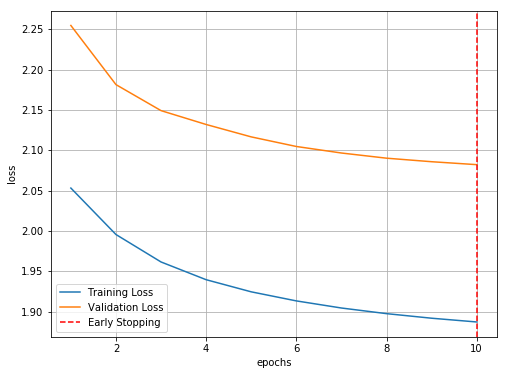

In [0]:
# Visualizing the loss as the network trained

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping')

plt.grid(True)
plt.legend()

plt.show()

## Test
<font size="4">
  Now you can compute the performance of the model on the unseen test data.
  
  </font>

In [0]:
# define evaluation metrics (acc, precision, recall, and f1-score)
from sklearn.metrics import precision_recall_fscore_support

class Evaluate():
    def __init__(self, out, labels):
        self.out = out.numpy().flatten()
        self.labels = labels.numpy().flatten()
    def accuracy(self):
        nb_correct = sum(y_t==y_p for y_t, y_p in zip(self.labels, self.out))
        nb_true = len(self.labels)
        score = nb_correct / nb_true
        return score
    def precision_recall_fscore(self, tag_list, average='macro'):
        return precision_recall_fscore_support(self.labels, self.out, 
                                                  average=average,labels=tag_list)[:-1]

In [0]:
# evaluate the model on test set 


all_preds = torch.LongTensor().to(device)
all_labels = torch.LongTensor().to(device)

with torch.no_grad():
    for sent, target in test_data_generator:
        sent, target = sent.to(device), target.to(device)
        tag_scores = model(sent)
        
        predict = tag_scores.data.max(2, keepdim=True)[1]        
        all_preds = torch.cat([all_preds, predict])
        all_labels = torch.cat([all_labels,target])
    
    all_preds, all_labels = all_preds.cpu(), all_labels.cpu()
    all_preds = all_preds.squeeze(dim=-1)
    evaluator = Evaluate(all_preds, all_labels)
    print('Overall Results on the Test set:')
    print('Accuracy\t{}'.format(evaluator.accuracy()))
    pr, rc, fm = evaluator.precision_recall_fscore(tag_list=[1,2,3]) # we ignore pad  
    print('Precision\t{}\nRecall\t\t{}\nF1-score\t{}'.format(pr,rc,fm))
    
    print('\n==================\n')
    
    print('# Results ignoring PAD and O:\n')
    tag_list = [1,2] # we ignore both pad and O
    pr, rc, fm = evaluator.precision_recall_fscore(tag_list)
    print('Precision\t{}\nRecall\t\t{}\nF1-score\t{}'.format(pr,rc,fm))         

Overall Results on the Test set:
Accuracy	0.9832388919216072
Precision	0.6824960815361895
Recall		0.8576102297676594
F1-score	0.7331814228090995


# Results ignoring PAD and O:

Precision	0.5356966662778412
Recall		0.8548201885809181
F1-score	0.6416834915543694


# * TO DO #1  
## Early Stopping
- End training if validation losses stagnate/increase 
- Save the best Model 

Hint: Have a quick look at this page to learn how to save/load models: https://bit.ly/2D7byMe 

# * TO DO #2
## Load pre-trained embbeding

Fill embedding_matrix

wv_file = embed_folder + FILE_NAME

wv_model = gensim.models.KeyedVectors.load_word2vec_format(wv_file)

embedding_matrix = wv_model.vectors

# * TO DO #3
## Add other layers or components to the Model

e.g. bi-directional LSTM


# * TO DO #4: Character Embeddibg

<font size="4"> 
*    Out-of-vocabulary (OOV) words are an issue in word embeddings that can negatively affect performance. For this reason it is helpful to have character-level features that can augment word representation. 
    
*    In some applications, sub-word units can provide helpful clues for the learning models. For these reasons, character embeddings are sometimes used in conjuction with word-level features. 

    
The overall process for creating combined word and character embeddings is depicted in the image below:
    
<figure>
<center>
<img src="https://drive.google.com/uc?id=1PiHd5B18-TH8vdpX62E6Sae4nUXmf6sD" />
<figcaption>word and character features</figcaption></center>
</figure>
  

Consider the word <i>gene</i>. The procedure is captured in more detail in the following diagram:

<figure>
<center>
<img src="https://drive.google.com/uc?id=1Zigj71mnsUqjcnona3BvKS6PCugVFIVe" 
     width="400" height="400"/>
<figcaption>source: https://www.aclweb.org/anthology/N18-1131</figcaption></center>
</figure>
    
</font>


<font size="4"> 
Similarly, in this exercise we augment the word embedding with character embedding using a character-based Bi-LSTM. More parameters would be added to the model and the `Dataset` and the `nn.Module` classes should be modified accordingly. 
    
More specifically, the following steps need to be completed in order to augment the model with character-based features:

1. Similar to words, characters should be indexed (with a specification for the maximum number of characters considered in a word) 

2. The Dataset class should be modified to return a character-encoded representation along with a word-based one 

3. The architecture of the baseline model should also be changed. Two separate Embedding layers are needed to embed the two representations. Two LSTM layers are also  required (word-based and character-based). This means new Embedding and LSTM layers should be defined in the `__init__` section of the class which would only receive the character-based representations in each batch. The outputs of the char-based LSTM and word-based Embedding are then concatenated to form the combined representation which would be finally fed to the main LSTM of the model. 
 
</font>

# * TO DO #5: Notes on Multi-task Learning

<font size="4"> 
  
  Multi-task learning is an approach for jointly training multiple models. It can be simply implemented in neural networks by learning tasks in parallel while using a shared representation.
  
The simplest way is when we have different outputs for the same input and simultaneously train a model to predict the two or more outputs. 
  
Parallel models can have both shared and independent layers.
  
  <figure>
<center>
<img src="https://drive.google.com/uc?id=1LdwHoHlwm2wQj6SHUazYkNcavTCJp1_X" width="400" height="300"/>
<figcaption>Multi-task learning</figcaption></center>
</figure>
  
In this excercise, we use the tags for chunking (which is provided in CONLL 2003 dataset in the third column) as our auxiliary outputs. The idea is that these two tasks can benefit from each other.
  
  
The sections of the code that should be modified for multi-tasking are as follows:
  


* Modify `readfile()`, to read the chunking column as well
* Create a dictionary that encode auxiliary tags
* Return auxiliary tags from class `CoNLL2003NER(Dataset)`
* Modify the model class. The architecture of the model will consist of one LSTM layer on top of embedding, then, two parallel LSTM layers, one to learn auxiliary tags and one to learn the main tags, and finally two Linear layers in similar fashion. The model returns two outputs accordingly.
* In the training loop, two losses will be computed, one for main tags predictions and one for auxiliary tags prediction. Backpropagation would be performed based on the addition of the two losses.
 
</font>